# Synthetic Dataset

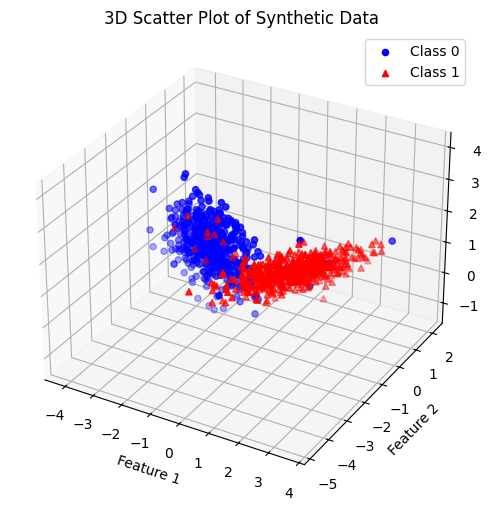

In [8]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with 3 features
X, y = make_classification(n_samples=1000, n_features=3, n_informative=3, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.5, 0.5], flip_y=0.05, class_sep=1.5)

# Plotting the dataset
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each class
ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], X[y == 0][:, 2], c='b', marker='o', label='Class 0')
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], X[y == 1][:, 2], c='r', marker='^', label='Class 1')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Synthetic Data')
ax.legend()

plt.show()


# Linear Classifier

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, num_features):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Instantiate the model
model = LinearClassifier(num_features=3)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Split data into training and testing
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for data, targets in train_loader:
        # Forward pass
        outputs = model(data).squeeze()
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [29]:
# Function to calculate accuracy
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data).squeeze()
            predicted = outputs.round()  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Accuracy on the test set
test_accuracy = calculate_accuracy(test_loader)
print(f'Accuracy of the linear classifier on test data is: {test_accuracy:.2f}%')


Accuracy of the linear classifier on test data is: 96.00%


# Labeling Functions

In [32]:
import torch

def lf1(x):
    # Label 1 if the first feature > 1, else 0
    return (x[:, 0] > 1).float()

def lf2(x):
    # Label 1 if the second feature > 0, else 0
    return (x[:, 1] > 0).float()

def lf_classifier(x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Ensure input is a PyTorch tensor and reshape it appropriately if it's just one sample
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Get the model's probability output
        probabilities = model(x).squeeze()
        
        # Convert probabilities to binary labels based on a 0.5 threshold
        labels = (probabilities >= 0.5).float()
        return labels

In [33]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [47]:
labels_lf1 = lf1(X_tensor)
labels_lf2 = lf2(X_tensor)
labels_lf3 = lf_classifier(X_tensor)


# Generative Model Training

In [53]:
# Initialize accuracy parameters for all three labeling functions
acc_lf1 = torch.tensor(0.5, requires_grad=True)
acc_lf2 = torch.tensor(0.5, requires_grad=True)
acc_lf3 = torch.tensor(0.5, requires_grad=True)  # New parameter for the classifier LF

# Optimizer includes the new accuracy parameter
optimizer = torch.optim.Adam([acc_lf1, acc_lf2, acc_lf3], lr=0.01)

# Define the training loop with marginal probability calculation including all three LFs
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Assuming binary class, calculate for both Y = 0 and Y = 1
    # Marginal probabilities given Y=1
    p_lf1_given_y1 = acc_lf1 * labels_lf1 + (1 - acc_lf1) * (1 - labels_lf1)
    p_lf2_given_y1 = acc_lf2 * labels_lf2 + (1 - acc_lf2) * (1 - labels_lf2)
    p_lf3_given_y1 = acc_lf3 * labels_lf3 + (1 - acc_lf3) * (1 - labels_lf3)
    
    # Marginal probabilities given Y=0
    p_lf1_given_y0 = (1 - acc_lf1) * labels_lf1 + acc_lf1 * (1 - labels_lf1)
    p_lf2_given_y0 = (1 - acc_lf2) * labels_lf2 + acc_lf2 * (1 - labels_lf2)
    p_lf3_given_y0 = (1 - acc_lf3) * labels_lf3 + acc_lf3 * (1 - labels_lf3)
    
    # Combine probabilities
    joint_prob_y1 = p_lf1_given_y1 * p_lf2_given_y1 * p_lf3_given_y1
    joint_prob_y0 = p_lf1_given_y0 * p_lf2_given_y0 * p_lf3_given_y0
    
    # Marginal probability over Y
    total_prob = 0.5 * (joint_prob_y1 + joint_prob_y0)  # Assuming P(Y=1) = P(Y=0) = 0.5
    
    # Negative log likelihood
    loss = -torch.log(total_prob + 1e-9).mean()  # small epsilon for numerical stability
    
    # Perform backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: LF1 Acc = {acc_lf1.item():.4f}, LF2 Acc = {acc_lf2.item():.4f}, LF3 Acc = {acc_lf3.item():.4f}")

# Optionally convert accuracy parameters to probabilities
# acc_lf1_prob = torch.sigmoid(acc_lf1)
# acc_lf2_prob = torch.sigmoid(acc_lf2)
# acc_lf3_prob = torch.sigmoid(acc_lf3)
# print(f"Final Estimated Accuracies: LF1 = {acc_lf1_prob.item():.4f}, LF2 = {acc_lf2_prob.item():.4f}, LF3 = {acc_lf3_prob.item():.4f}")


Epoch 0: LF1 Acc = 0.5000, LF2 Acc = 0.4931, LF3 Acc = 0.5000
Epoch 100: LF1 Acc = -0.3920, LF2 Acc = 0.2710, LF3 Acc = 0.1667
Epoch 200: LF1 Acc = -1.1599, LF2 Acc = 0.2340, LF3 Acc = 0.1818
Epoch 300: LF1 Acc = -1.8054, LF2 Acc = 0.2229, LF3 Acc = 0.1862
Epoch 400: LF1 Acc = -2.3916, LF2 Acc = 0.2171, LF3 Acc = 0.1882
Epoch 500: LF1 Acc = -2.9424, LF2 Acc = 0.2135, LF3 Acc = 0.1904
Epoch 600: LF1 Acc = -3.4686, LF2 Acc = 0.2105, LF3 Acc = 0.1915
Epoch 700: LF1 Acc = -3.9775, LF2 Acc = 0.2099, LF3 Acc = 0.1907
Epoch 800: LF1 Acc = -4.4732, LF2 Acc = 0.2075, LF3 Acc = 0.1914
Epoch 900: LF1 Acc = -4.9591, LF2 Acc = 0.2069, LF3 Acc = 0.1915
Epoch 1000: LF1 Acc = -5.4372, LF2 Acc = 0.2055, LF3 Acc = 0.1926
Epoch 1100: LF1 Acc = -5.9097, LF2 Acc = 0.2055, LF3 Acc = 0.1916
Epoch 1200: LF1 Acc = -6.3770, LF2 Acc = 0.2046, LF3 Acc = 0.1925
Epoch 1300: LF1 Acc = -6.8418, LF2 Acc = 0.2045, LF3 Acc = 0.1928
Epoch 1400: LF1 Acc = -7.3043, LF2 Acc = 0.2031, LF3 Acc = 0.1925
Epoch 1500: LF1 Acc = -